In [149]:
import pandas as pd
import numpy as np
from Bio import SeqIO
from Bio.Data import CodonTable
from Bio.Seq import Seq
from Bio.SeqUtils import seq3
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.transforms import TransformedBbox
import re
from scipy.stats import mannwhitneyu

#set to true to reverse complement codons in codon table (heatmap part only! fracs have the same trigger in calculate_aa_fracs.py)
REV_COMP = True

# AA Fracs

### Positive genes


In [150]:
fracs = pd.read_csv('/home/gabs/Documents/lab/TermitesAndCockroaches/mtdna-mutspec-insecta/data/DescriptiveStat/midori_Blattodea_aa_fracs.tsv', sep = '\t')

In [151]:
fracs

,Species_name,Organism,Gene_name,Phe_frac,Leu_frac,Leu2_frac,Ser_frac,Pro_frac,Cys_frac,Trp_frac,...,Ser2_frac,Asp_frac,Glu_frac,Asn_frac,Lys_frac,Val_frac,Ile_frac,Met_frac,Ala_frac,Thr_frac
0,Acanthotermes_acanthothorax_187525,Termites,A6,0.052863,0.017621,0.004405,0.088106,0.008811,0.083700,0.066079,...,0.008811,0.088106,0.061674,0.017621,0.030837,0.101322,0.008811,0.013216,0.022026,0.004405
1,Acanthotermes_acanthothorax_187525,Termites,A8,0.094340,0.056604,0.037736,0.056604,0.000000,0.094340,0.018868,...,0.037736,0.037736,0.075472,0.018868,0.018868,0.113208,0.056604,0.000000,0.018868,0.000000
2,Acanthotermes_acanthothorax_187525,Termites,CO1,0.029183,0.017510,0.007782,0.145914,0.003891,0.089494,0.068093,...,0.023346,0.048638,0.075875,0.036965,0.033074,0.105058,0.011673,0.009728,0.009728,0.007782
3,Acanthotermes_acanthothorax_187525,Termites,CO2,0.047619,0.051948,0.012987,0.090909,0.008658,0.082251,0.073593,...,0.012987,0.056277,0.043290,0.043290,0.004329,0.121212,0.021645,0.017316,0.034632,0.008658
4,Acanthotermes_acanthothorax_187525,Termites,CO3,0.045627,0.034221,0.003802,0.136882,0.007605,0.121673,0.068441,...,0.019011,0.049430,0.079848,0.034221,0.026616,0.106464,0.011407,0.015209,0.011407,0.011407
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3258,Zootermopsis_nevadensis_136037,Termites,ND3,0.076271,0.016949,0.016949,0.093220,0.016949,0.127119,0.059322,...,0.008475,0.067797,0.033898,0.050847,0.050847,0.050847,0.008475,0.008475,0.008475,0.000000
3259,Zootermopsis_nevadensis_136037,Termites,ND4,0.006726,0.002242,0.026906,0.022422,0.047085,0.004484,0.015695,...,0.123318,0.008969,0.006726,0.121076,0.141256,0.004484,0.040359,0.060538,0.002242,0.130045
3260,Zootermopsis_nevadensis_136037,Termites,ND4L,0.000000,0.020833,0.041667,0.010417,0.031250,0.000000,0.010417,...,0.072917,0.000000,0.000000,0.125000,0.177083,0.000000,0.041667,0.104167,0.000000,0.135417
3261,Zootermopsis_nevadensis_136037,Termites,ND5,0.006957,0.005217,0.027826,0.027826,0.038261,0.001739,0.005217,...,0.146087,0.001739,0.008696,0.137391,0.165217,0.001739,0.059130,0.055652,0.003478,0.104348


In [152]:
for gene in ['ND5', 'ND4', 'ND4L', 'ND1']:
    fracs = fracs.drop(fracs[fracs['Gene_name'] == gene].index)
fracs = fracs.drop(columns=['Gene_name'])
frac_types = ['Phe_frac', 'Leu_frac',
       'Leu2_frac', 'Ser_frac', 'Pro_frac', 'Cys_frac', 'Trp_frac', 'Tyr_frac',
       'Arg_frac', 'His_frac', 'Gln_frac', 'Gly_frac', 'Ser2_frac', 'Asp_frac',
       'Glu_frac', 'Asn_frac', 'Lys_frac', 'Val_frac', 'Ile_frac', 'Met_frac',
       'Ala_frac', 'Thr_frac']

In [153]:
ter_fracs = fracs[fracs['Organism'] == 'Termites']
cock_fracs = fracs[fracs['Organism'] == 'Cockroaches']

def transform_table(df, organism):
    sp_frac = {}
    sp_list = []
    frac_type_list = []
    frac_val_list = []
    for sp in df['Species_name'].unique():
        sp_list.append([sp] * len(frac_types))
        frac_type_list.append(df[df['Species_name'] == sp].drop(columns=['Species_name', 'Organism']).mean().index)
        frac_val_list.append(df[df['Species_name'] == sp].drop(columns=['Species_name', 'Organism']).mean().values)
        sp_frac[sp] = df[df['Species_name'] == sp].drop(columns=['Species_name', 'Organism']).mean()
    
    
    df = pd.DataFrame()
    for i in range(len(sp_list)):
        df = pd.concat([df, pd.DataFrame([sp_list[i], frac_type_list[i], frac_val_list[i]]).T])
    df = df.rename(columns={0:'Species_name', 1:'Frac_type', 2:'Frac_val'})
    df['Organism'] = organism
    return df

cock_fracs = transform_table(cock_fracs, 'Cockroaches')
term_fracs = transform_table(ter_fracs, 'Termites')

fracs_merged = pd.concat([term_fracs, cock_fracs])

/usr/lib/python3/dist-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/lib/python3/dist-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/lib/python3/dist-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/lib/python3/dist-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


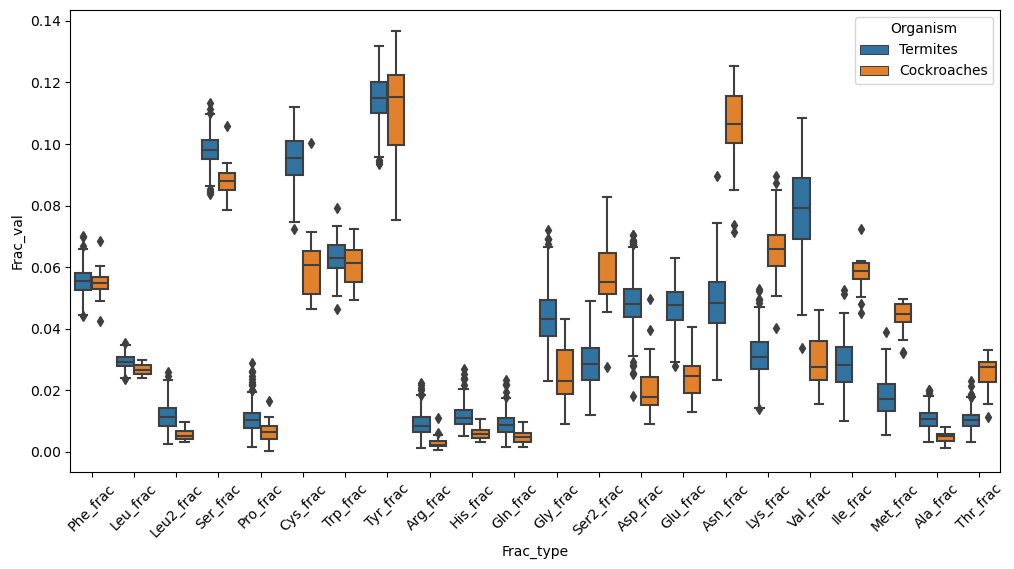

In [154]:
plt.figure(figsize=(12, 6))
ax = sns.boxplot(x='Frac_type',
                y="Frac_val",
                hue='Organism',
                data=fracs_merged)
ax.tick_params(axis='x', labelrotation=45)

### Negative genes


/usr/lib/python3/dist-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/lib/python3/dist-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/lib/python3/dist-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/lib/python3/dist-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


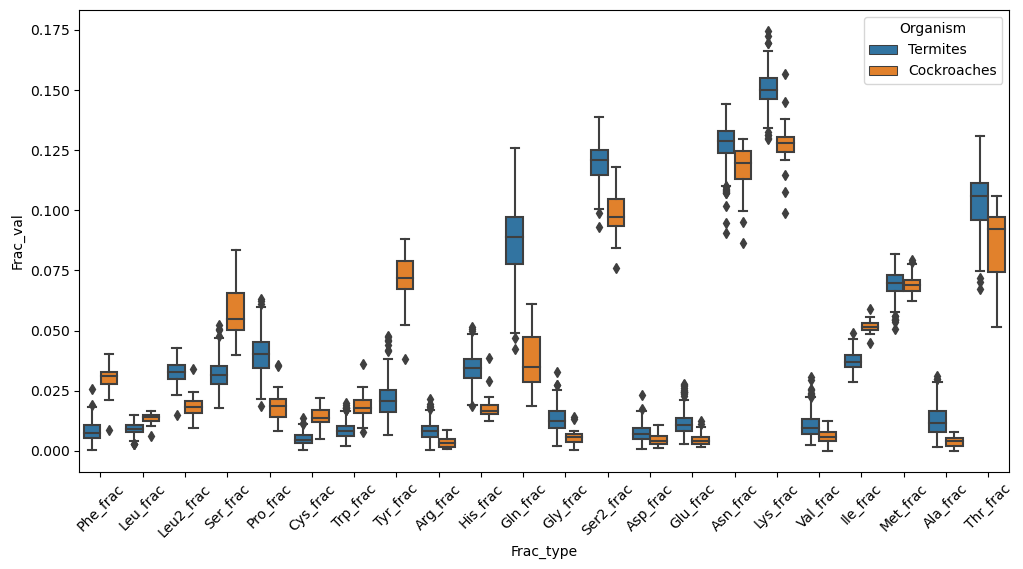

In [155]:
fracs = pd.read_csv('/home/gabs/Documents/lab/TermitesAndCockroaches/mtdna-mutspec-insecta/data/DescriptiveStat/midori_Blattodea_aa_fracs.tsv', sep = '\t')
for gene in ['A6', 'A8', 'CO1', 'CO2', 'CO3', 'Cytb', 'ND2', 'ND3', 'ND6']:
    fracs = fracs.drop(fracs[fracs['Gene_name'] == gene].index)
fracs = fracs.drop(columns=['Gene_name'])
frac_types = ['Phe_frac', 'Leu_frac',
       'Leu2_frac', 'Ser_frac', 'Pro_frac', 'Cys_frac', 'Trp_frac', 'Tyr_frac',
       'Arg_frac', 'His_frac', 'Gln_frac', 'Gly_frac', 'Ser2_frac', 'Asp_frac',
       'Glu_frac', 'Asn_frac', 'Lys_frac', 'Val_frac', 'Ile_frac', 'Met_frac',
       'Ala_frac', 'Thr_frac']

ter_fracs = fracs[fracs['Organism'] == 'Termites']
cock_fracs = fracs[fracs['Organism'] == 'Cockroaches']

cock_fracs = transform_table(cock_fracs, 'Cockroaches')
term_fracs = transform_table(ter_fracs, 'Termites')

fracs_merged = pd.concat([term_fracs, cock_fracs])

plt.figure(figsize=(12, 6))
ax = sns.boxplot(x='Frac_type',
                y="Frac_val",
                hue='Organism',
                data=fracs_merged)
ax.tick_params(axis='x', labelrotation=45)

# Heatmap


### Positive genes


In [156]:
codon_table = pd.read_csv('/home/gabs/Documents/lab/TermitesAndCockroaches/mtdna-mutspec-insecta/data/DescriptiveStat/codontable_midori_Blattodea.csv', index_col=0)

In [157]:
if REV_COMP == True:
    #reverse complementing
    codons = ['TTT', 'TTC', 'TTA', 'TTG', 'TCT', 'TCC',
           'TCA', 'TCG', 'TAT', 'TAC', 'TGT', 'TGC', 'TGG', 'CTT', 'CTC', 'CTA',
           'CTG', 'CCT', 'CCC', 'CCA', 'CCG', 'CAT', 'CAC', 'CAA', 'CAG', 'CGT',
           'CGC', 'CGA', 'CGG', 'ATT', 'ATC', 'ATA', 'ATG', 'ACT', 'ACC', 'ACA',
           'ACG', 'AAT', 'AAC', 'AAA', 'AAG', 'AGT', 'AGC', 'AGA', 'AGG', 'GTT',
           'GTC', 'GTA', 'GTG', 'GCT', 'GCC', 'GCA', 'GCG', 'GAT', 'GAC', 'GAA',
           'GAG', 'GGT', 'GGC', 'GGA', 'GGG', 'TAA', 'TAG', 'TGA']
    revcomp_codons = {}
    for cod in codons:
        revcomp = Seq(cod).reverse_complement()
        revcomp_codons[cod] = str(revcomp)
    codon_table.rename(columns=revcomp_codons, inplace=True)

In [158]:
for gene in ['ND5', 'ND4', 'ND4L', 'ND1']:
    codon_table = codon_table.drop(codon_table[codon_table['Gene_name'] == gene].index)

In [159]:
to_drop = ['Species_name','GenbankID', 'Taxonomy', 'Gene_name',
       'Gene_start_end_and_trend', 'GeneID', 'Aminoacids_from_genbank',
       'Translated_aminoacids_by_Python', 'Not_standart_codons',
       'Wrong_amino_num', 'Wrong_nucl_num', 'wrong_amino_%', 'Sequence',
       'mtDNA_length', 'nA', 'nT', 'nC', 'nG', 'nNA', '%A', '%T', '%C', '%G',
       '%NA', 'neutralA', 'neutralG', 'neutralC', 'neutralT', 'Neutral_count']
codon_table = codon_table.drop(columns=to_drop)

In [160]:
codon_table.loc[codon_table['Workers'] == 1.0, 'Workers'] = 'Termite'
codon_table.loc[codon_table['Workers'] == 0.0, 'Workers'] = 'Termite'
codon_table['Workers'] = codon_table['Workers'].fillna('Cockroach')
codon_table = codon_table.rename(columns={'Workers':'Species'})

/tmp/ipykernel_19830/2542088553.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'Termite' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  codon_table.loc[codon_table['Workers'] == 1.0, 'Workers'] = 'Termite'


In [161]:
def draw_heat_map_mito(df_heatmap_codon_change_value, df_heatmap_codon_change_name,
                  df_heatmap_codon_change_aa, file_name,
                  cmd=sns.palettes.blend_palette(('#ffffff10', '#ff0000af'), 6, as_cmap=True), 
                  title='Heatmap'):
    # cmd palette - from white to red
# Three DataFrames on import in function first - with values, second - text in heatmap cells, 
# three - amino acids that are printed on heatmap (the presence of empty cells in the data frame matters)
    fig, ax=plt.subplots(figsize=(18,18))
    # make heatmap on values and annotation is text from second DataFrame
    sns.heatmap(df_heatmap_codon_change_value, annot=df_heatmap_codon_change_name, fmt='', annot_kws={"ha":'left',"size":15}, cmap=cmd)
    # Here I add Amino acids on plot by coordiate
    for y in range(df_heatmap_codon_change_aa.shape[0]):
        for x in range(df_heatmap_codon_change_aa.shape[1]):
            plt.text(x+0.03, y+0.07, df_heatmap_codon_change_aa.iloc[y,x],horizontalalignment='left',verticalalignment='top',color='black',fontsize=25)

    # Label options
    ax.set_yticks(np.arange(0,16,1))
    ax.set_ylabel('First Nucleotide',size=20)
    ax.set_xlabel('Second Nucleotide',size=20)
    ax.set_title(title,size=20)
    ax.set_yticklabels(('', '', 'T', '', '', '', 'C', '', '', '', 'A', '', '', '', 'G', ''), 
        rotation=0, fontsize="30", va="center")
    plt.xticks(fontsize=30)
    # Here I add boxes around the amino acids the coordinates of the beginning are indicated in parentheses 
    # (0, 0) - top left
    # below is the value of the box in width (everywhere 1) and length (how many codons are included in the amino acid)
    ax.add_patch(
         patches.Rectangle(
             (0, 0),
             1.0,
             2.0,
             edgecolor='black',
             fill=False,
             lw=4
         ) )
    ax.add_patch(
         patches.Rectangle(
             (0, 2),
             1.0,
             2.0,
             edgecolor='black',
             fill=False,
             lw=4
         ) )
    ax.add_patch(
         patches.Rectangle(
             (0, 4),
             1.0,
             4.0,
             edgecolor='black',
             fill=False,
             lw=4
         ) )
    ax.add_patch(
         patches.Rectangle(
             (0, 8),
             1.0,
             2.0,
             edgecolor='black',
             fill=False,
             lw=4
         ) )
    ax.add_patch(
         patches.Rectangle(
             (0, 10),
             1.0,
             2.0,
             edgecolor='black',
             fill=False,
             lw=4
         ) )
    ax.add_patch(
         patches.Rectangle(
             (0, 12),
             1.0,
             4.0,
             edgecolor='black',
             fill=False,
             lw=4
         ) )
    ax.add_patch(
         patches.Rectangle(
             (1, 0),
             1.0,
             4.0,
             edgecolor='black',
             fill=False,
             lw=4
         ) )
    ax.add_patch(
         patches.Rectangle(
             (1, 4),
             1.0,
             4.0,
             edgecolor='black',
             fill=False,
             lw=4
         ) )
    ax.add_patch(
         patches.Rectangle(
             (1, 8),
             1.0,
             4.0,
             edgecolor='black',
             fill=False,
             lw=4
         ) )
    ax.add_patch(
         patches.Rectangle(
             (1, 12),
             1.0,
             4.0,
             edgecolor='black',
             fill=False,
             lw=4
         ) )
    ax.add_patch(
         patches.Rectangle(
             (2, 0),
             1.0,
             2.0,
             edgecolor='black',
             fill=False,
             lw=4
         ) )
    ax.add_patch(
         patches.Rectangle(
             (2, 0),
             1.0,
             4.0,
             edgecolor='black',
             fill=False,
             lw=4
         ) )
    ax.add_patch(
         patches.Rectangle(
             (2, 2),
             1.0,
             2.0,
             edgecolor='black',
             fill=False,
             lw=4
         ) )
    ax.add_patch(
         patches.Rectangle(
             (2, 4),
             1.0,
             2.0,
             edgecolor='black',
             fill=False,
             lw=4
         ) )
    ax.add_patch(
         patches.Rectangle(
             (2, 6),
             1.0,
             2.0,
             edgecolor='black',
             fill=False,
             lw=4
         ) )
    ax.add_patch(
         patches.Rectangle(
             (2, 8),
             1.0,
             2.0,
             edgecolor='black',
             fill=False,
             lw=4
         ) )
    ax.add_patch(
         patches.Rectangle(
             (2, 10),
             1.0,
             2.0,
             edgecolor='black',
             fill=False,
             lw=4
         ) )
    ax.add_patch(
         patches.Rectangle(
             (2, 12),
             1.0,
             2.0,
             edgecolor='black',
             fill=False,
             lw=4
         ) )
    ax.add_patch(
         patches.Rectangle(
             (2, 14),
             1.0,
             2.0,
             edgecolor='black',
             fill=False,
             lw=4
         ) )
    ax.add_patch(
         patches.Rectangle(
             (3, 0),
             1.0,
             2.0,
             edgecolor='black',
             fill=False,
             lw=4
         ) )
    ax.add_patch(
         patches.Rectangle(
             (3, 2),
             1.0,
             2.0,
             edgecolor='black',
             fill=False,
             lw=4
         ) )
    ax.add_patch(
         patches.Rectangle(
             (3, 4),
             1.0,
             4.0,
             edgecolor='black',
             fill=False,
             lw=4
         ) )
    ax.add_patch(
         patches.Rectangle(
             (3, 8),
             1.0,
             2.0,
             edgecolor='black',
             fill=False,
             lw=4
         ) )
    ax.add_patch(
         patches.Rectangle(
             (3, 10),
             1.0,
             2.0,
             edgecolor='black',
             fill=False,
             lw=4
         ) )
    ax.add_patch(
         patches.Rectangle(
             (3, 12),
             1.0,
             4.0,
             edgecolor='black',
             fill=False,
             lw=4
         ) )
    plt.show()
    #fig.savefig(f'{file_name}.pdf', dpi=300)

/tmp/ipykernel_19830/1452804098.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  table_for_heatmap = pd.concat([df, table_for_heatmap])
/tmp/ipykernel_19830/1452804098.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  table_for_heatmap['for_count'][i] = i
/tmp/ipykernel_19830/1452804098.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  table_for_heatmap['for_count

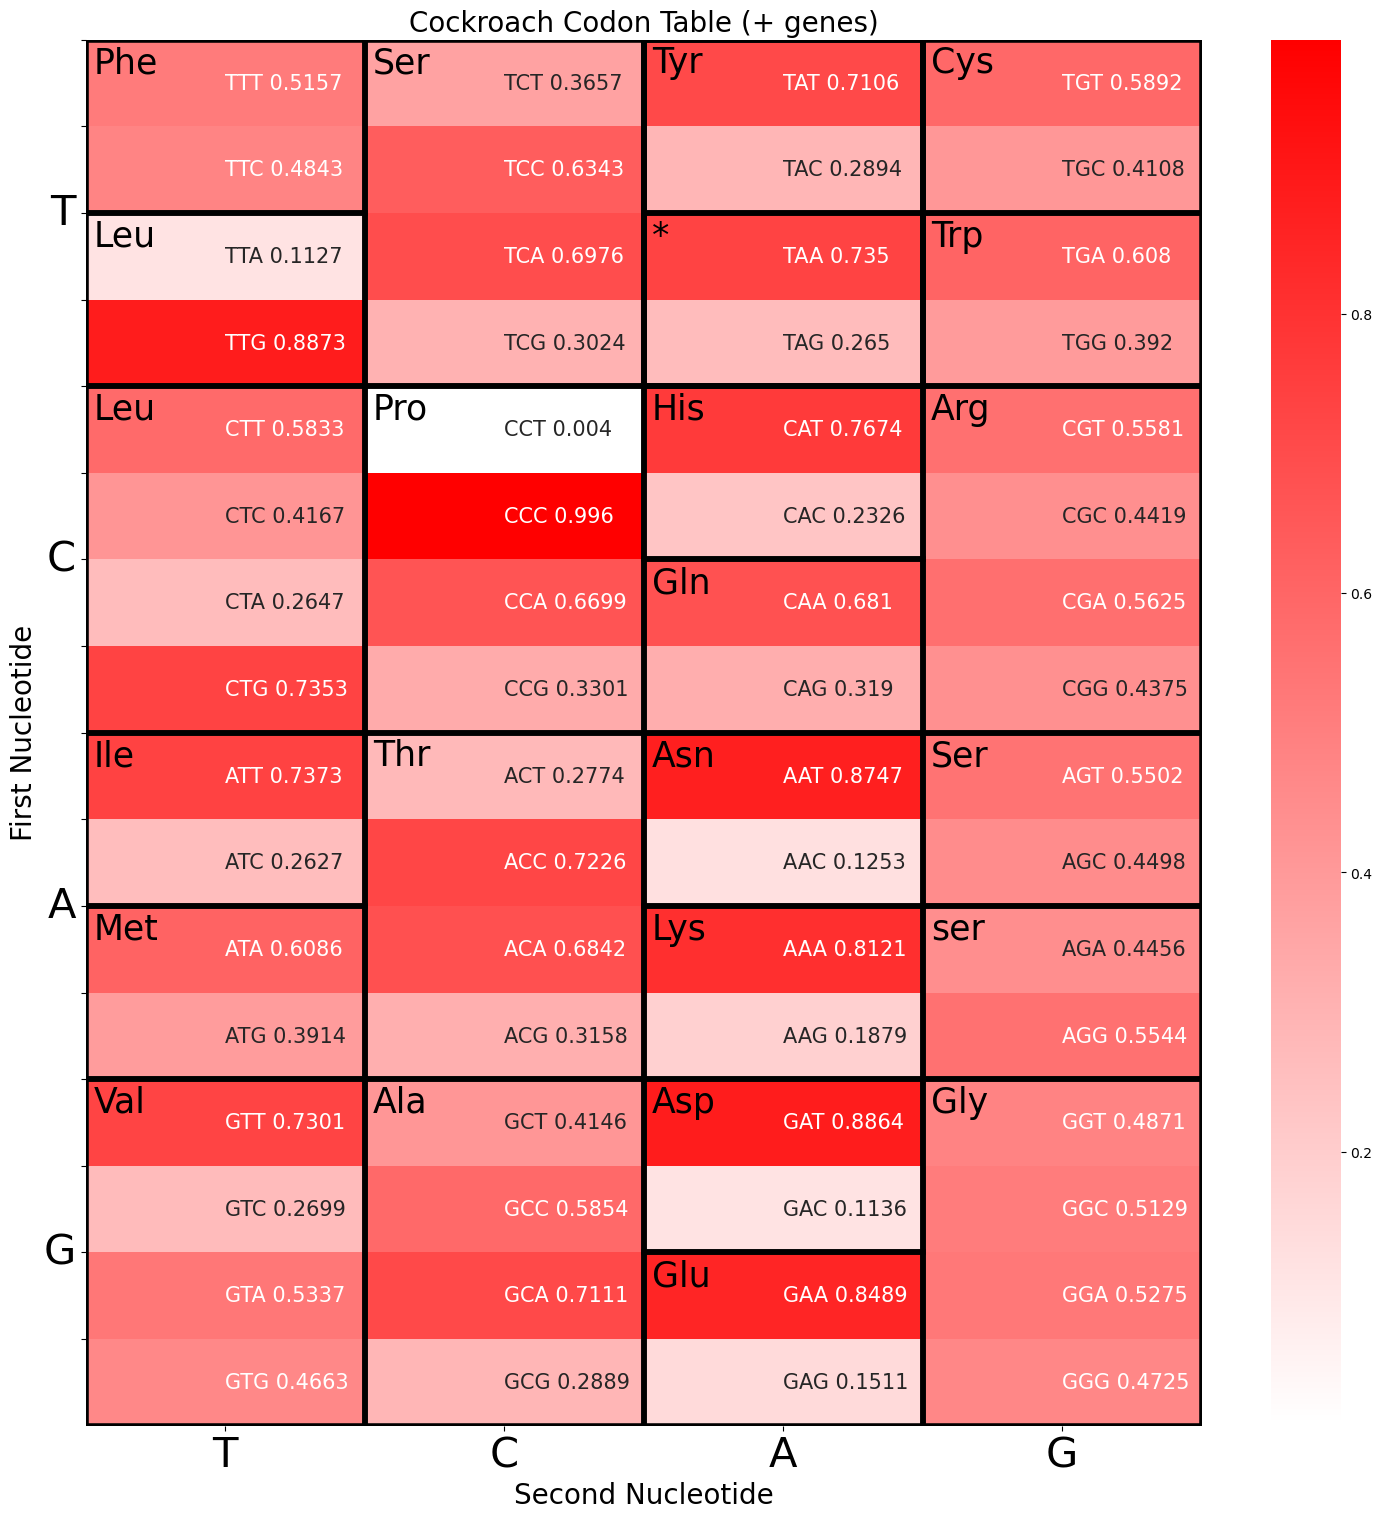

In [162]:
df = codon_table[codon_table['Species'] == 'Cockroach']
df = df.iloc[:, 1:].mean().to_frame().T
df.insert(loc=0, column="Species", value='Cockroach')

# Make list with all codons
codons_t = []
nuc_one = ['A', 'T', 'G', 'C']
nuc_two = ['A', 'T', 'G', 'C']
nuc_three = ['A', 'T', 'G', 'C']
for first in nuc_one:
    for second in nuc_two:
        for three in nuc_three:
            codons_t.append(first+second+three)

# Please, change the name of organism if it is neccessary
organism = 'Cockroach'
name = organism
#Select only organism and codons, tar_ros name comes from original selected species
df_tar_ros = df[df['Species'] == organism][codons_t].reset_index(drop=True)

table_for_heatmap = pd.DataFrame(columns=['codon', 'aa', 'codon_count'])

index_num = 0
for codon in df_tar_ros.columns:
    codon_name = codon
    # Make amino acids from codons
    aa_name = seq3(Seq(codon).translate()[0])
    value = df_tar_ros[codon].sum()
    data = {'codon':codon_name, 'aa':aa_name, 'codon_count':value}
    df = pd.DataFrame(data, index=[index_num])
    table_for_heatmap = pd.concat([df, table_for_heatmap])
    index_num+=1

#small changes to the mitochondrial code, for sure it can be done using biopython, but I'm too lazy to look
table_for_heatmap.loc[table_for_heatmap['codon'] == 'ATA','aa'] = 'Met'
table_for_heatmap.loc[table_for_heatmap['codon'] == 'TGA','aa'] = 'Trp'
table_for_heatmap.loc[table_for_heatmap['codon'] == 'AGA','aa'] = 'Ser'
table_for_heatmap.loc[table_for_heatmap['codon'] == 'AGG','aa'] = 'Ser'

# for sorting by nucleotides levels - TCAG, if you change it - change everywhere in code
table_for_heatmap['first_nucl'] = table_for_heatmap['codon'].astype(str).str[0]
table_for_heatmap['second_nucl'] = table_for_heatmap['codon'].astype(str).str[1]
table_for_heatmap['three_nucl'] = table_for_heatmap['codon'].astype(str).str[2]
table_for_heatmap['first_nucl'] = pd.Categorical(table_for_heatmap['first_nucl'],categories=list('TCAG'))
table_for_heatmap['second_nucl'] = pd.Categorical(table_for_heatmap['second_nucl'],categories=list('TCAG'))
table_for_heatmap['three_nucl'] = pd.Categorical(table_for_heatmap['three_nucl'],categories=list('TCAG'))

# sorting
table_for_heatmap = table_for_heatmap.sort_values(by=['second_nucl','first_nucl','three_nucl']).reset_index(drop=True)

# this is crutch for summing codons that are located nearby, every two codons - one number and after - sum by number
table_for_heatmap['for_count'] = 0
for i in range(0,len(table_for_heatmap),2):
    table_for_heatmap['for_count'][i] = i
    table_for_heatmap['for_count'][i+1] = i

# count fractions of neighboring codons
table_for_heatmap['codon_prop'] = 0.
for index, row in table_for_heatmap.iterrows():
    if table_for_heatmap[table_for_heatmap['for_count'] == table_for_heatmap['for_count'][index]]['codon_count'].sum() != 0:
        table_for_heatmap['codon_prop'][index] = table_for_heatmap['codon_count'][index] / table_for_heatmap[table_for_heatmap['for_count'] == table_for_heatmap['for_count'][index]]['codon_count'].sum()

# make three different DF for heatmap
c_value = list(table_for_heatmap[table_for_heatmap['second_nucl'] == 'C']['codon_prop'])
u_value = list(table_for_heatmap[table_for_heatmap['second_nucl'] == 'T']['codon_prop'])
g_value = list(table_for_heatmap[table_for_heatmap['second_nucl'] == 'G']['codon_prop'])
a_value = list(table_for_heatmap[table_for_heatmap['second_nucl'] == 'A']['codon_prop'])
df_heatmap_codon_change_value = pd.DataFrame({'T':u_value, 'C':c_value, 'A':a_value, 'G':g_value})

name_df = table_for_heatmap[['codon', 'aa', 'codon_prop', 'second_nucl']]
name_df.loc[name_df.duplicated('aa'), 'aa'] = ''
name_df.loc[name_df['codon'] == 'CTT','aa'] = 'Leu'
name_df.loc[name_df['codon'] == 'AGT','aa'] = 'Ser'
name_df.loc[name_df['codon'] == 'AGA','aa'] = 'ser'
name_df.loc[name_df['codon'] == 'TAA','aa'] = '*'
name_df['codon_prop'] = round(name_df['codon_prop'],4).astype('str')
name_df['summ_info'] = name_df['codon'] + ' ' + name_df['codon_prop']
c_name = list(name_df[name_df['second_nucl'] == 'C']['summ_info'])
u_name = list(name_df[name_df['second_nucl'] == 'T']['summ_info'])
g_name = list(name_df[name_df['second_nucl'] == 'G']['summ_info'])
a_name = list(name_df[name_df['second_nucl'] == 'A']['summ_info'])
df_heatmap_codon_change_name = pd.DataFrame({'T':u_name, 'C':c_name, 'A':a_name, 'G':g_name})

c_aa = list(name_df[name_df['second_nucl'] == 'C']['aa'])
u_aa = list(name_df[name_df['second_nucl'] == 'T']['aa'])
g_aa = list(name_df[name_df['second_nucl'] == 'G']['aa'])
a_aa = list(name_df[name_df['second_nucl'] == 'A']['aa'])
df_heatmap_codon_change_aa = pd.DataFrame({'T':u_aa, 'C':c_aa, 'A':a_aa, 'G':g_aa})

#call function for drawing
draw_heat_map_mito(df_heatmap_codon_change_value, df_heatmap_codon_change_name, 
              df_heatmap_codon_change_aa, f'{name}', title=f'{name} Codon Table (+ genes)')

/tmp/ipykernel_19830/2956673172.py:30: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  table_for_heatmap = pd.concat([df, table_for_heatmap])
/tmp/ipykernel_19830/2956673172.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  table_for_heatmap['for_count'][i] = i
/tmp/ipykernel_19830/2956673172.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  table_for_heatmap['for_count

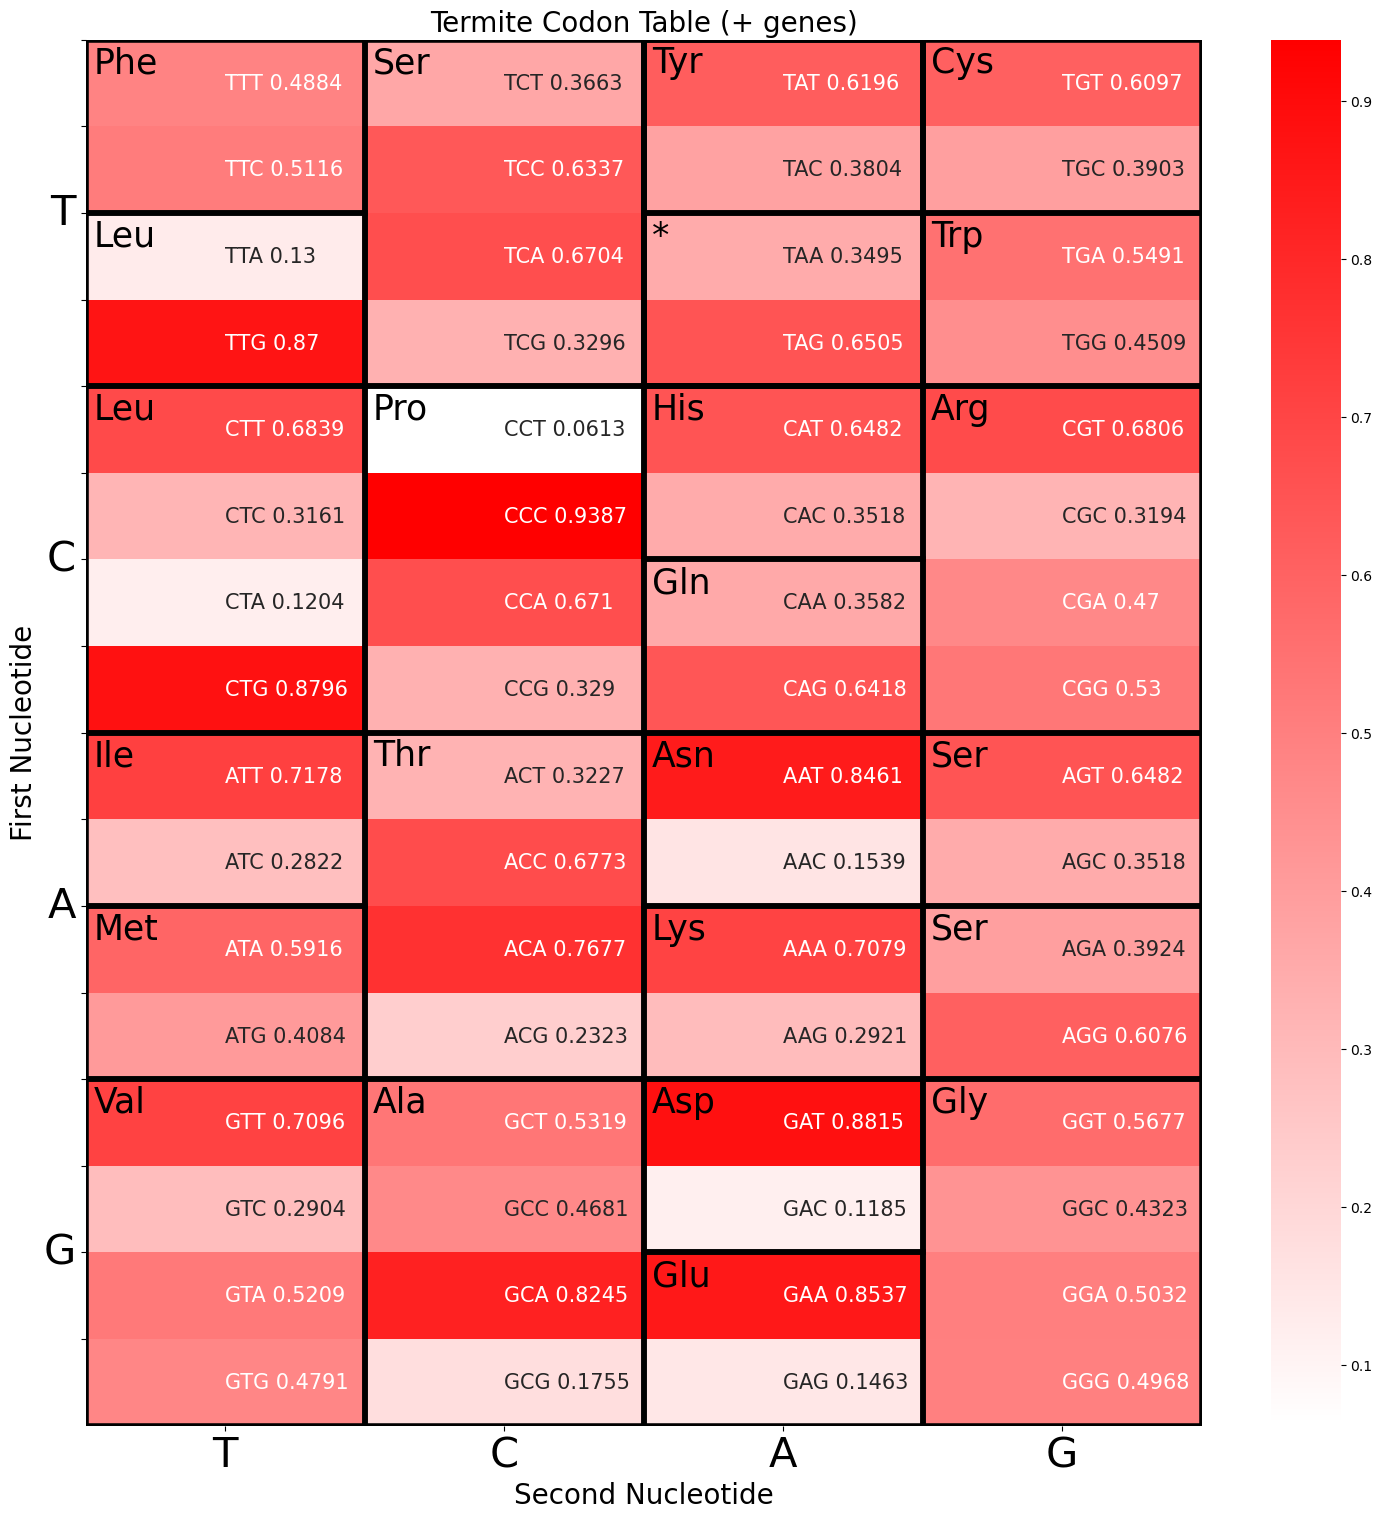

In [163]:
df = codon_table[codon_table['Species'] == 'Termite']
df = df.iloc[:, 1:].mean().to_frame().T
df.insert(loc=0, column="Species", value='Termite')
# Make list with all codons
codons_t = []
nuc_one = ['A', 'T', 'G', 'C']
nuc_two = ['A', 'T', 'G', 'C']
nuc_three = ['A', 'T', 'G', 'C']
for first in nuc_one:
    for second in nuc_two:
        for three in nuc_three:
            codons_t.append(first+second+three)

# Please, change the name of organism if it is neccessary
organism = 'Termite'
name = organism
#Select only organism and codons, tar_ros name comes from original selected species
df_tar_ros = df[df['Species'] == organism][codons_t].reset_index(drop=True)

table_for_heatmap = pd.DataFrame(columns=['codon', 'aa', 'codon_count'])

index_num = 0
for codon in df_tar_ros.columns:
    codon_name = codon
    # Make amino acids from codons
    aa_name = seq3(Seq(codon).translate()[0])
    value = df_tar_ros[codon].sum()
    data = {'codon':codon_name, 'aa':aa_name, 'codon_count':value}
    df = pd.DataFrame(data, index=[index_num])
    table_for_heatmap = pd.concat([df, table_for_heatmap])
    index_num+=1

#small changes to the mitochondrial code, for sure it can be done using biopython, but I'm too lazy to look
table_for_heatmap.loc[table_for_heatmap['codon'] == 'ATA','aa'] = 'Met'
table_for_heatmap.loc[table_for_heatmap['codon'] == 'TGA','aa'] = 'Trp'
table_for_heatmap.loc[table_for_heatmap['codon'] == 'AGA','aa'] = 'Ser'
table_for_heatmap.loc[table_for_heatmap['codon'] == 'AGG','aa'] = 'Ser'

# for sorting by nucleotides levels - TCAG, if you change it - change everywhere in code
table_for_heatmap['first_nucl'] = table_for_heatmap['codon'].astype(str).str[0]
table_for_heatmap['second_nucl'] = table_for_heatmap['codon'].astype(str).str[1]
table_for_heatmap['three_nucl'] = table_for_heatmap['codon'].astype(str).str[2]
table_for_heatmap['first_nucl'] = pd.Categorical(table_for_heatmap['first_nucl'],categories=list('TCAG'))
table_for_heatmap['second_nucl'] = pd.Categorical(table_for_heatmap['second_nucl'],categories=list('TCAG'))
table_for_heatmap['three_nucl'] = pd.Categorical(table_for_heatmap['three_nucl'],categories=list('TCAG'))

# sorting
table_for_heatmap = table_for_heatmap.sort_values(by=['second_nucl','first_nucl','three_nucl']).reset_index(drop=True)

# this is crutch for summing codons that are located nearby, every two codons - one number and after - sum by number
table_for_heatmap['for_count'] = 0
for i in range(0,len(table_for_heatmap),2):
    table_for_heatmap['for_count'][i] = i
    table_for_heatmap['for_count'][i+1] = i

# count fractions of neighboring codons
table_for_heatmap['codon_prop'] = 0.
for index, row in table_for_heatmap.iterrows():
    if table_for_heatmap[table_for_heatmap['for_count'] == table_for_heatmap['for_count'][index]]['codon_count'].sum() != 0:
        table_for_heatmap['codon_prop'][index] = table_for_heatmap['codon_count'][index] / table_for_heatmap[table_for_heatmap['for_count'] == table_for_heatmap['for_count'][index]]['codon_count'].sum()

# make three different DF for heatmap
c_value = list(table_for_heatmap[table_for_heatmap['second_nucl'] == 'C']['codon_prop'])
u_value = list(table_for_heatmap[table_for_heatmap['second_nucl'] == 'T']['codon_prop'])
g_value = list(table_for_heatmap[table_for_heatmap['second_nucl'] == 'G']['codon_prop'])
a_value = list(table_for_heatmap[table_for_heatmap['second_nucl'] == 'A']['codon_prop'])
df_heatmap_codon_change_value = pd.DataFrame({'T':u_value, 'C':c_value, 'A':a_value, 'G':g_value})

name_df = table_for_heatmap[['codon', 'aa', 'codon_prop', 'second_nucl']]
name_df.loc[name_df.duplicated('aa'), 'aa'] = ''
name_df.loc[name_df['codon'] == 'CTT','aa'] = 'Leu'
name_df.loc[name_df['codon'] == 'AGT','aa'] = 'Ser'
name_df.loc[name_df['codon'] == 'AGA','aa'] = 'Ser'
name_df.loc[name_df['codon'] == 'TAA','aa'] = '*'
name_df['codon_prop'] = round(name_df['codon_prop'],4).astype('str')
name_df['summ_info'] = name_df['codon'] + ' ' + name_df['codon_prop']
c_name = list(name_df[name_df['second_nucl'] == 'C']['summ_info'])
u_name = list(name_df[name_df['second_nucl'] == 'T']['summ_info'])
g_name = list(name_df[name_df['second_nucl'] == 'G']['summ_info'])
a_name = list(name_df[name_df['second_nucl'] == 'A']['summ_info'])
df_heatmap_codon_change_name = pd.DataFrame({'T':u_name, 'C':c_name, 'A':a_name, 'G':g_name})

c_aa = list(name_df[name_df['second_nucl'] == 'C']['aa'])
u_aa = list(name_df[name_df['second_nucl'] == 'T']['aa'])
g_aa = list(name_df[name_df['second_nucl'] == 'G']['aa'])
a_aa = list(name_df[name_df['second_nucl'] == 'A']['aa'])
df_heatmap_codon_change_aa = pd.DataFrame({'T':u_aa, 'C':c_aa, 'A':a_aa, 'G':g_aa})

#call function for drawing
draw_heat_map_mito(df_heatmap_codon_change_value, df_heatmap_codon_change_name, 
              df_heatmap_codon_change_aa, f'{name}', title=f'{name} Codon Table (+ genes)')